In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn import tree
import graphviz 
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.graph_objs import *
from sklearn.mixture import GaussianMixture
from pandas.tools.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn import utils
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import math
from sklearn.linear_model import LinearRegression

In [202]:
#Load data into dataframe
df = pd.read_csv("Airbnb_Surveys/new_york/s3_files/new_york/tomslee_airbnb_new_york_1438_2017-07-12.csv")

In [203]:
#Drop useless identifiers

df = df.drop(columns=['room_id','survey_id', 'host_id', 'country', 'city', 'last_modified', 'location','bathrooms'])
df = df[df.bedrooms<50]

Plot by borough to see if there are any obvious separations in the data

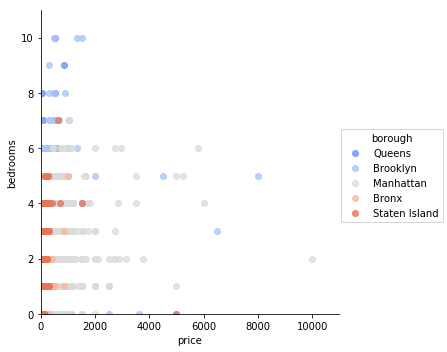

In [98]:
g = sns.lmplot(x="price",y="bedrooms", data=df, hue='borough', palette = sns.color_palette('coolwarm',5),fit_reg=False)
g= (g.set(xlim=(0,11000), ylim=(0,11)))

It does appear to be the case! Queens and Brooklyn seem to have more rooms at lower expenses while Manhattan is obviously the most expensive housing

Let's reduce our data further to make it easier to handle - we're only going to be ignoring location variables for now. We'll also group each level of satisfaction by the average reviews, bedrooms and price and see if we can draw any insights from that

In [99]:
reduced_df =  df[['reviews','bedrooms','price','overall_satisfaction']]
reduced_df.groupby('overall_satisfaction').mean()


,reviews,bedrooms,price
overall_satisfaction,,,
0.0,0.608028,1.148228,142.897822
1.0,3.500000,1.000000,80.000000
1.5,3.000000,1.000000,41.500000
2.0,3.400000,1.600000,189.800000
2.5,3.500000,1.333333,89.166667
3.0,6.982143,1.178571,118.696429
3.5,10.194553,1.198444,109.719844
4.0,25.919108,1.238217,115.494268
4.5,35.174679,1.189859,123.560874


It appears that the places with the lowest_overall satisfaction have minimal reviews and the extremely high prices! Could it be that the high prices contribute to low satisfaction? Let's look at a histogram of the satisfaction levels

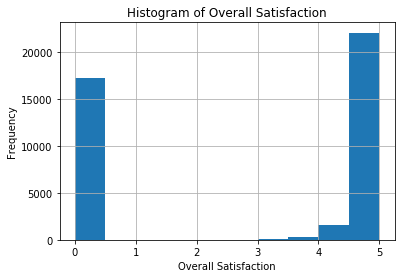

In [105]:
#Histogram of overall satisfaction
df.overall_satisfaction.hist()
plt.title('Histogram of Overall Satisfaction')
plt.xlabel('Overall Satisfaction')
plt.ylabel('Frequency')
plt.show()

The data is very heavily skewed towards 0 and 5 stars - that's not necessarily good. We probably won't be able to get too much useful information about a place if people don't really rate it very accurately.

Note that there are basically no 1-2.5 stars (look at csv with a filter on overall_satisfaction and it becomes very apparent). 

Let's look a different variable - bedrooms. Maybe this could provide more useful insight

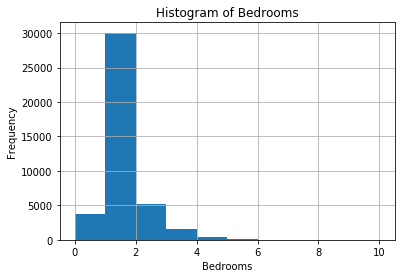

In [104]:
#Histogram of bedrooms
df.bedrooms.hist(range=(0,10))
plt.title('Histogram of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Frequency')
plt.show()

Very heavily skewed towards the left end, but that's not particularly surprising. After all, most places aren't going to have a large number of bedrooms, especially in NYC.

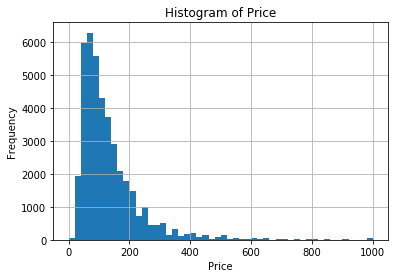

In [106]:
#Histogram of overall satisfaction
df.price.hist(bins=50, range=(0,1000))
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

This seems useful! We've limited the price of places shown since the frequency for very pricey places is so low, it makes the plot of the data seem off. From the plot, it appears that the price appears to follow a exponential distribution, making it less likely that more expensive places will exist - again, this is to be expected. People have to compete for guests, so naturally prices will cluster towards the cheaper end in order to attract more guests.


Can any clustering be performed on the currently available data? Let's try a simple k-means and see if data will naturally group together based on the number of bedrooms.

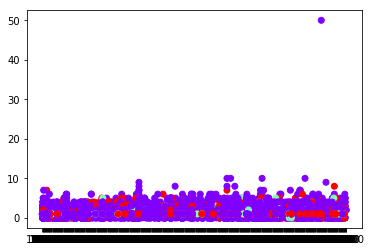

In [127]:
X = df[['reviews','bedrooms','overall_satisfaction']]
y = df[['price']]

kmeans = KMeans(n_clusters=3)  
kmeans.fit(X)

plt.scatter(y, X['bedrooms'],c=kmeans.labels_, cmap='rainbow')
plt.show()

There's too much noise to be able to tell apart any group! Let's take a sample of the data and see if that can clear things up a bit. Let's also increase the number of possible clusters to see if anything pops up.

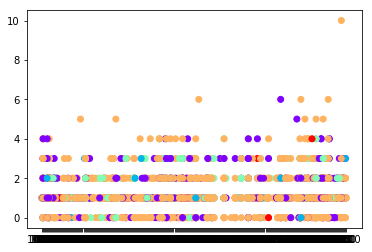

In [132]:
frac_X = df[['reviews','bedrooms','overall_satisfaction']].sample(frac=0.1)
frac_y = df[['price']].sample(frac=0.1)

kmeans = KMeans(n_clusters=5)  
kmeans.fit(frac_X)

plt.scatter(frac_y, frac_X['bedrooms'],c=kmeans.labels_, cmap='rainbow')
plt.show()

It looks like the data won't cluster very easily then, at least with bedrooms and pricing, even if they follow fairly similar distributions. Let's try PCA, perhaps keeping more data might create some more obvious clusters.

In [134]:
pca = PCA(n_components=2)
pca.fit(reduced_df)
print("PCA Components: ",pca.components_)
print("Explained Variance: ",pca.explained_variance_)

X_pca = pca.fit_transform(reduced_df)
print("original shape:   ", reduced_df.shape)
print("transformed shape:", X_pca.shape)
print(reduced_df.keys())

PCA Components:  [[-6.45802305e-03  1.41964504e-03  9.99978049e-01 -4.25483437e-04]
 [ 9.99452817e-01  7.60651941e-04  6.46734958e-03  3.24293294e-02]]
Explained Variance:  [27762.0537227   1018.66360662]
original shape:    (41245, 4)
transformed shape: (41245, 2)
Index(['reviews', 'bedrooms', 'price', 'overall_satisfaction'], dtype='object')


c:\users\fernando\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning:

The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.



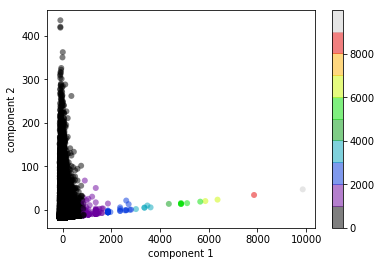

In [137]:
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=reduced_df.price, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();


Well that's not too useful, maybe we should cut down on the component range to prevent the clustering from working only on the extremes.

c:\users\fernando\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning:

The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.



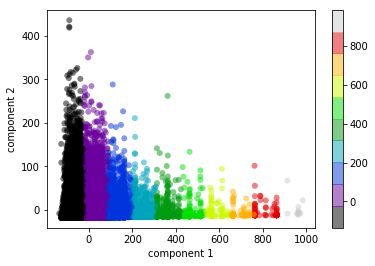

In [139]:
new_X_pca = X_pca[X_pca[:,0]<1000]

plt.scatter(new_X_pca[:, 0], new_X_pca[:, 1],
            c=new_X_pca[:,0], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

The data continues to follow the same sort of distribution, and the clustering via PCA simply splits evenly along the components (I have a feeling here the price is dominating the PCA). So let's try eliminating it.


In [161]:
no_price_df = reduced_df.drop(columns='price')

pca = PCA(n_components=2)
pca.fit(no_price_df)
print("PCA Components: ",pca.components_)
print("Explained Variance: ",pca.explained_variance_)

no_price_pca = pca.fit_transform(no_price_df)
print("original shape:   ", no_price_df.shape)
print("transformed shape:", no_price_pca.shape)
print(no_price_df.keys())

PCA Components:  [[ 9.99472641e-01  5.09715346e-04  3.24681487e-02]
 [ 3.24689163e-02 -1.57778862e-03 -9.99471500e-01]]
Explained Variance:  [1019.78225523    4.38900104]
original shape:    (41245, 3)
transformed shape: (41245, 2)
Index(['reviews', 'bedrooms', 'overall_satisfaction'], dtype='object')


c:\users\fernando\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning:

The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.



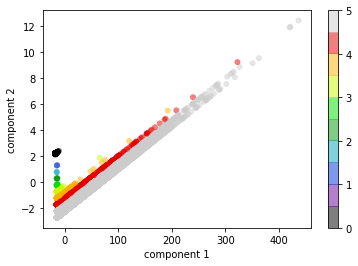

In [165]:
plt.scatter(no_price_pca[:, 0], no_price_pca[:, 1],
            c=no_price_df.overall_satisfaction, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()


So this is less than ideal. It appears there is no obvious way to cluster the data into groups unless we really start cutting down on it. So let's do that.

original shape:    (40503, 4)
transformed shape: (40503, 4)


c:\users\fernando\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning:

The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.



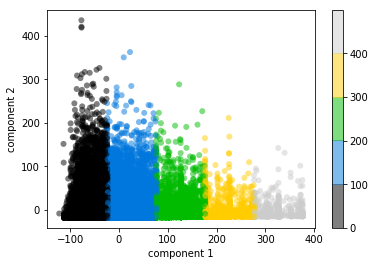

In [177]:
#Consider only places that are $1000 or less/night
reduced_price_df = reduced_df[reduced_df.price<500]

red_price_pca = PCA(n_components=4)
red_price_pca.fit(reduced_price_df)
rpdf_pca = pca.fit_transform(reduced_price_df)
print("original shape:   ", reduced_price_df.shape)
print("transformed shape:", rpdf_pca.shape)
plt.scatter(rpdf_pca[:, 0], rpdf_pca[:, 1],
            c=reduced_price_df.price, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 5))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

Even when reducing the amount of data available to a more specific subset, there isn't clear groups of the data

Using a Gaussian Mixture Model will perhaps allow us to determine group boundaries.

In [187]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.4 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

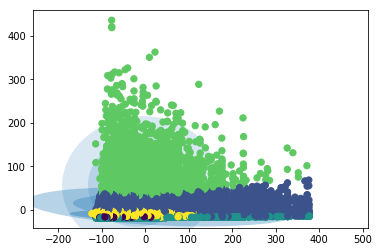

In [196]:
gmm = GaussianMixture(n_components=5)
#print(GaussianMixture.__dict__)
plot_gmm(gmm, rpdf_pca[:,0:2])

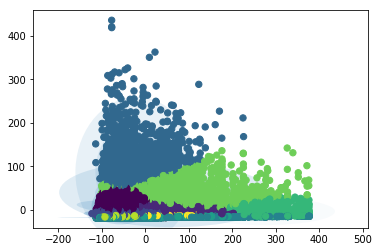

In [197]:
gmm = GaussianMixture(n_components=10)
plot_gmm(gmm, rpdf_pca[:,0:2])

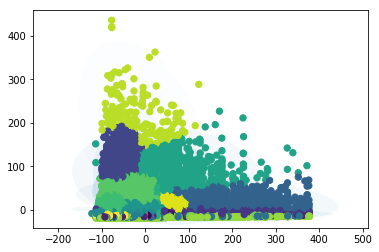

In [198]:
gmm = GaussianMixture(n_components=20)
plot_gmm(gmm, rpdf_pca[:,0:2])

Still a large amount of overlap between the groups, even when trying different numbers of groupings.

We'll now plot a scatter matrix of the data to see how it looks.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000229176DE2B0>,
      dtype=object)

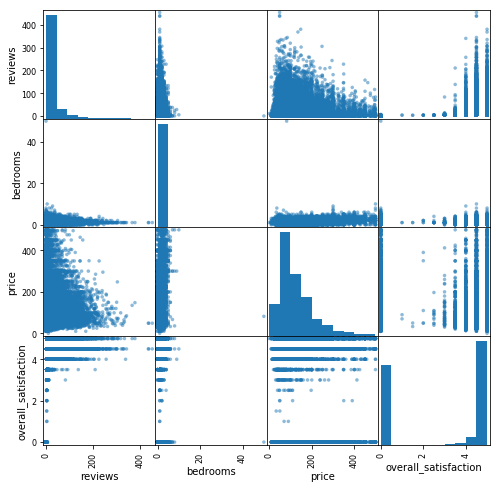

In [204]:
pd.plotting.scatter_matrix(reduced_price_df,alpha=0.5, figsize=(8, 8), diagonal='hist', s=50)

Nothing we haven't seen before.

In [24]:
###     What are we looking for?     ###
#Sample input

accom = int(input())
beds = int(input())
price = int(input())
price_range = int(input())
min_reviews = int(input())

4
4
300
100
10


Since clustering via k-means/gaussian mixture didn't really turn out useful, we'll turn to regression analysis. If we attempt to predict prices based off of attributes from the data maybe we'll get something useful out of it

Text(0.5,0,'price')

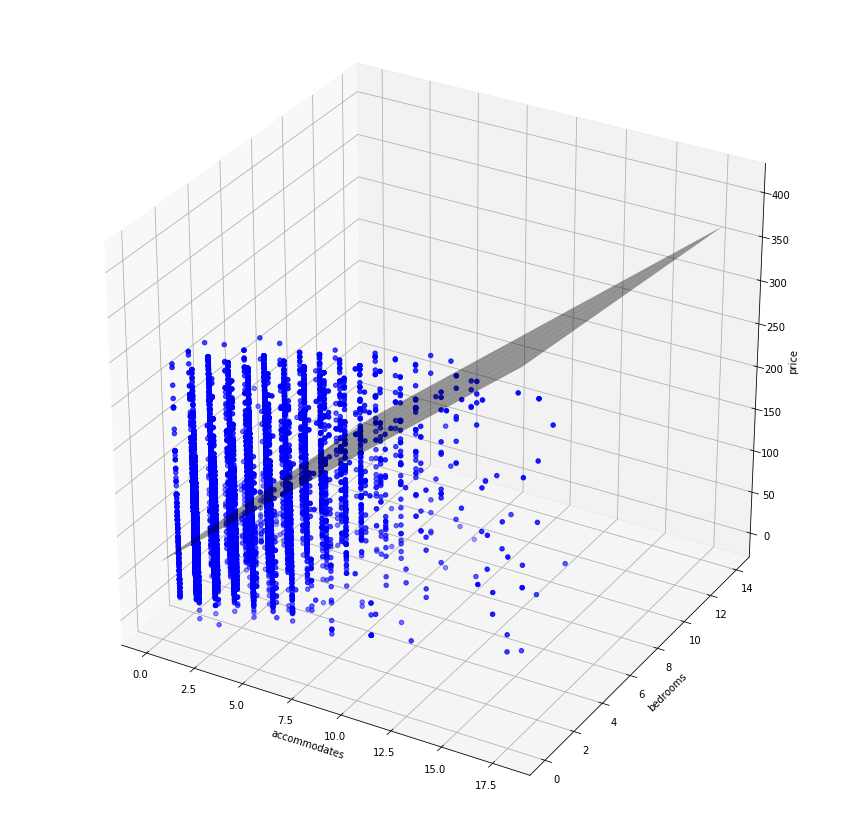

In [225]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

reduced_price_df = df[df.price<300]

X = reduced_price_df[['reviews','bedrooms','accommodates']]
y = reduced_price_df[['price']]


regr_1 = LinearRegression()
regr_1.fit(X[['accommodates','bedrooms']], y)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

x_surf = np.arange(0, 20, 2)
y_surf = np.arange(0, 15, 2)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)

new_x = pd.core.frame.DataFrame({'accommodates': x_surf.ravel(), 'bedrooms': y_surf.ravel()})
predict_price = regr_1.predict(new_x)
ax.plot_surface(x_surf, y_surf,
                predict_price.reshape(x_surf.shape),
                rstride=1,
                cstride=1,
                color='None',
                alpha = 0.4)

ax.scatter(X['accommodates'], X['bedrooms'], y, c='blue')

ax.set_xlabel('accommodates')
ax.set_ylabel('bedrooms')
ax.set_zlabel('price')

Trying to fit a hyperplane to the data doesn't seem like it's working out all too well - it's much too spread apart.

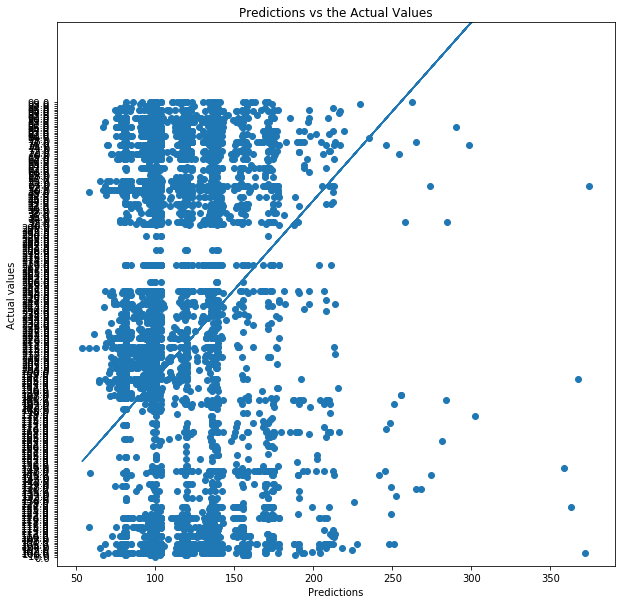

Regression Score:  0.22267059255877297


In [233]:
new_X = X
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, y, test_size=0.2, random_state=1)

regr_2 = LinearRegression()
regr_2.fit(new_X_train, new_y_train)

plt.figure(figsize=(10, 10))
plt.scatter(regr_2.predict(new_X_test), new_y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual values')
plt.title('Predictions vs the Actual Values')
plt.plot(regr_2.predict(new_X_test),regr_2.predict(new_X_test))
plt.ylim(-5,300)
plt.show()
print("Regression Score: ",regr_2.score(new_X_test, new_y_test))

In [234]:
#Set parameters
another_df = df[['reviews','accommodates','bedrooms','price']]
another_df = another_df[another_df.price<=(price+price_range)]
another_df = another_df[another_df.price>=(price-price_range)]
another_df = another_df[another_df.bedrooms>=beds]
another_df = another_df[another_df.accommodates>=accom]
another_df = another_df[another_df.reviews>=min_reviews]

another_y = another_df['price']
another_X = another_df[['accommodates','reviews']]

# Split the targets into training/testing sets
another_X_train_data, another_X_test_data, another_y_train_data, another_y_test_data = train_test_split(another_X, another_y, test_size=0.2, random_state=1)
#Create a linear regression object
regr_3 = LinearRegression()

# Train the model using the training sets
regr_3.fit(another_X_train_data, another_y_train_data)


# The coefficients
print('Coefficients: \n', regr_3.coef_)
print('accommodates, reviews')
# The mean square error
print("Residual sum of squares: %.2f" %np.mean((regr_3.predict(another_X_test_data) - another_y_test_data) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr_3.score(another_X_test_data, another_y_test_data))

Coefficients: 
 [ 3.31796482 -0.1718317 ]
accommodates, reviews
Residual sum of squares: 4087.72
Variance score: 0.02


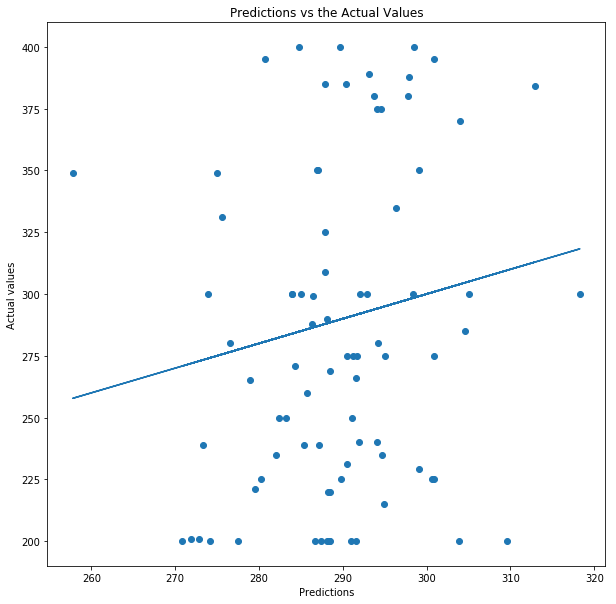

In [235]:
another_new_X = another_X
another_new_X_train, another_new_X_test, another_new_y_train, another_new_y_test = train_test_split(another_new_X, another_y, test_size=0.2, random_state=1)

regr_3.fit(another_new_X_train, another_new_y_train)

plt.figure(figsize=(10, 10))
plt.scatter(regr_3.predict(another_new_X_test), another_new_y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual values')
plt.title('Predictions vs the Actual Values')
#plt.plot(new_y_test, new_y_test)
plt.plot(regr_3.predict(another_new_X_test),regr_3.predict(another_new_X_test))
plt.show()

This clearly is terrible. Something has to be done. What is we instead replace a range of price values with 0's and 1's, so that when the price is within the range we're looking for we have price marked as 1, else 0

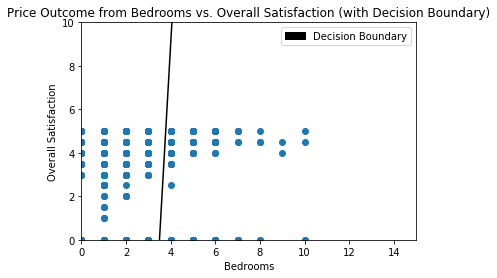

In [240]:
#Specify x and y data
df = df[df.bedrooms<50]
X = df[["bedrooms","overall_satisfaction"]]
y = df["price"]


price_range=100
price=300
min_reviews=0


#Split data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)


y_test = y_test.replace(range(0,200),0)
y_test = y_test.replace(range(400,10000),0)
y_test = y_test.replace(range(200,400),1)
y_train = y_train.replace(range(0,200),0)
y_train = y_train.replace(range(400,10000),0)
y_train = y_train.replace(range(200,400),1)

#Train model
model = LogisticRegression(penalty = "l1")
fit = model.fit(X_train,y_train)

#Specify legend colors for decision boundary
black_patch = mpatches.Patch(color='black', label='Decision Boundary')

#Scatter Plot
plt.scatter(x=df["bedrooms"], y=df["overall_satisfaction"])
plt.title("Price Outcome from Bedrooms vs. Overall Satisfaction (with Decision Boundary)")
plt.xlabel("Bedrooms")
plt.ylabel("Overall Satisfaction")
plt.legend(handles=[black_patch])

#Calculate Decision Boundary
b = fit.intercept_
coef = fit.coef_[0]

x = np.arange(0, 1000, 1)
#print(len(b))###numpy arange dependent on changing size of b
y = (b + coef[0] * x) / (-coef[1])

#Plot boundary
plt.plot(x, y, color='black')
plt.ylim(0, 10)
plt.xlim(0,15)
plt.show()

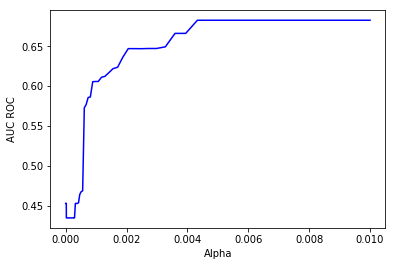

Optimal alpha: 0.004328761281083062


In [241]:
alphas = np.logspace(-6,-2,100)
score = []

#Calculate the optimal alpha to use
for alpha in alphas:
    regr = LogisticRegression(C=alpha, penalty='l2')
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    score.append(roc_auc)
    
alpha_max_score = alphas[np.argmax(score)]

#Plot alphas to see how they improve over time
plt.plot(alphas, score, color='blue')
plt.xlabel('Alpha')
plt.ylabel('AUC ROC')
plt.show()
print("Optimal alpha:", alpha_max_score)

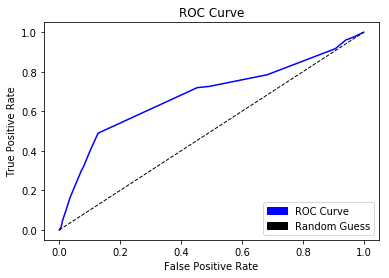

Area under the ROC curve: 0.682563201334489


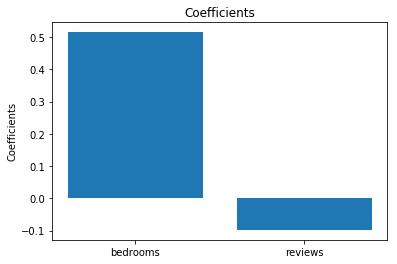

Coefficients:  [ 0.51465202 -0.09796201]


In [242]:
#Regression
regr = LogisticRegression(C=alpha_max_score, penalty='l2')
regr.fit(X_train, y_train)

#Colors
roc_curve_patch = mpatches.Patch(color='blue', label='ROC Curve')
random_guess_patch = mpatches.Patch(color='black', label='Random Guess')

#Plot ROC
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1],  linestyle='--',lw=1, color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(handles=[roc_curve_patch, random_guess_patch], loc="lower right")
plt.show()
print ("Area under the ROC curve:", roc_auc)

# Plot coefficients
fig, ax = plt.subplots()
ax.bar(np.linspace(0,1,2),regr.coef_[0])
ax.set_ylabel('Coefficients')
ax.set_title('Coefficients')
ax.set_xticks(np.arange(2))
ax.set_xticklabels(('bedrooms', 'overall_satisfaction'))

plt.show()

print("Coefficients: ", *regr.coef_)

With only two coefficients, we can accurately predict whether or not the place we're looking at is within our price range (although one of them is fairly useless...)

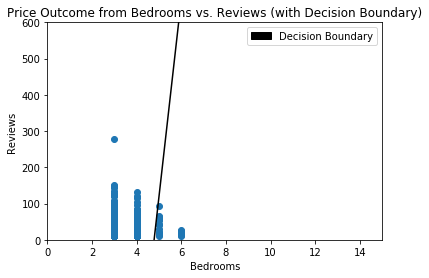

In [252]:
price_range=100
price=300
min_reviews=10
min_satisfaction = 3
beds = 3

#Sample input
df = df[df.overall_satisfaction>=min_satisfaction]
df = df[df.bedrooms>=3]
df = df[df.reviews>=min_reviews]
df = df[df.borough=='Manhattan']

#Create datdframes
X = df[["bedrooms","reviews","overall_satisfaction"]]
y = df["price"]

#Split data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)


y_test = y_test.replace(range(0,200),0)
y_test = y_test.replace(range(400,10000),0)
y_test = y_test.replace(range(200,400),1)
y_train = y_train.replace(range(0,200),0)
y_train = y_train.replace(range(400,10000),0)
y_train = y_train.replace(range(200,400),1)

#Train model
model = LogisticRegression(penalty = "l2")
fit = model.fit(X_train,y_train)

#Specify legend colors for decision boundary
black_patch = mpatches.Patch(color='black', label='Decision Boundary')

#Scatter Plot
plt.scatter(x=df["bedrooms"], y=df["reviews"])
plt.title("Price Outcome from Bedrooms vs. Reviews (with Decision Boundary)")
plt.xlabel("Bedrooms")
plt.ylabel("Reviews")
plt.legend(handles=[black_patch])

#Calculate Decision Boundary
b = fit.intercept_
coef = fit.coef_[0]

x = np.arange(0, 1000, 1)
#print(len(b))###numpy arange dependent on changing size of b
y = (b + coef[0] * x) / (-coef[1])

#Plot boundary
plt.plot(x, y, color='black')
plt.ylim(0, 600)
plt.xlim(0,15)
plt.show()

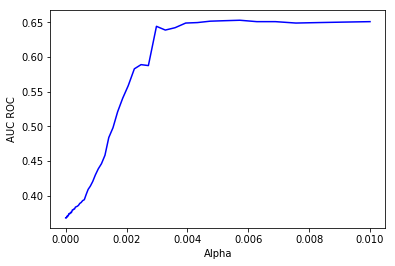

Optimal alpha: 0.00572236765935022


In [255]:
alphas = np.logspace(-6,-2,100)
score = []

#Calculate the optimal alpha to use
for alpha in alphas:
    regr = LogisticRegression(C=alpha, penalty='l2')
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    score.append(roc_auc)
    
alpha_max_score = alphas[np.argmax(score)]
alpha_min_score = alphas[np.argmin(score)]

#Plot alphas to see how they improve over time
plt.plot(alphas, score, color='blue')
plt.xlabel('Alpha')
plt.ylabel('AUC ROC')
plt.show()
print("Optimal alpha:", alpha_max_score)

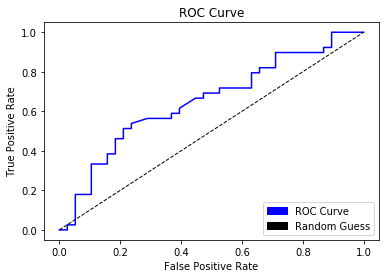

Area under the ROC curve: 0.6511470985155196


In [258]:
#Regression
regr = LogisticRegression(C=alpha_min_score, penalty='l1')
regr.fit(X_train, y_train)

#Colors
roc_curve_patch = mpatches.Patch(color='blue', label='ROC Curve')
random_guess_patch = mpatches.Patch(color='black', label='Random Guess')

#Plot ROC
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1],  linestyle='--',lw=1, color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(handles=[roc_curve_patch, random_guess_patch], loc="lower right")
plt.show()
print ("Area under the ROC curve:", roc_auc)